Dependencies

In [11]:
!pip install --upgrade -r requirements.txt
!sudo apt-get install -y ffmpeg mkvtoolnix


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
mkvtoolnix is already the newest version (54.0.0+really52.0.0-3).
ffmpeg is already the newest version (7:4.3.6-0+deb11u1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


Let's extract out the audio, so we have a clean look for our audio processing tools to take a look. (We can also get chapters and subtitles, but, we'll deal with those later!)

In [7]:
fn = "[a-s]_mobile_fighter_g_gundam_-_03_-_beat_the_dragon_gundam__rs2_[0678D2EE].mkv"

import pymkv
from pymkv import MKVFile
mkv = MKVFile(fn)
found_jpn = False
found_eng = False
created_folders = []
for track in mkv.get_track(None):
    print(track.track_id, track.track_type, track.language, track.track_name)
    if track.track_type == "subtitles" or track.track_type == "audio":
        if track.language_ietf == "ja-JP" or track.language == "jpn":
            found_jpn = True
        elif (track.language_ietf or "").startswith("en-") or track.language == "eng":
            found_eng = True
        folder = "%s_%s" % (track.track_type, track.language)
        track.extract(folder, silent=True)
        created_folders.append(folder)
print("Created: %s" % (", ".join(created_folders),))


2.0.0
0 video jpn AVC
1 audio eng AAC
2 audio jpn AAC
3 subtitles eng ASS
4 subtitles jpn ASS
Created: audio_eng, audio_jpn, subtitles_eng, subtitles_jpn


In [8]:
!(cd audio_jpn && ffmpeg -i *.aac audio.wav) # figure out some way to do this with python? or rust?


ffmpeg version 4.3.6-0+deb11u1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

The below gets a list of audio features using the left channel... But this is too much! We need training data. Let's see how much we can get from the *obvious* extracts first.

['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std', 'delta zcr', 'delta energy', 'delta energy_entropy', 'delta spectral_centroid', 'delta spectral_spread', 'delta spectral_entropy', 'delta spectral_flux', 'delta spectral_rolloff', 'delta mfcc_1', 'delta mfcc_2', 'delta mfcc_3', 'delta mfcc_4', 'delta mfcc_5', 'delta mfcc_6', 'delta mfcc_7', 'delta mfcc_8', 'delta mfcc_9', 'delta mfcc_10', 'delta mfcc_11', 'delta mfcc_12', 'delta mfcc_13', 'delta chroma_1', 'delta chroma_2', 'delta chroma_3', 'delta chroma_4', 'delta chroma_5', 'delta chroma_6', 'delta chroma_7', 'delta chroma_8', 'delta chroma_9', 'delta chroma_10',

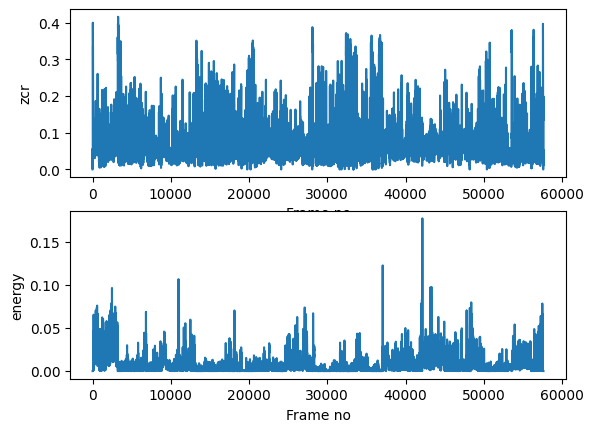

In [5]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt
import numpy as np

[sample_rate, signal] = audioBasicIO.read_audio_file("audio_jpn/audio.wav")
if np.shape(signal)[1] != 2:
    raise "Mono audio not supported"

left_channel = signal[:, 0]
F, f_names = ShortTermFeatures.feature_extraction(left_channel, sample_rate, 0.050 * sample_rate, 0.025 * sample_rate)
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0])
plt.subplot(2,1,2); plt.plot(F[1,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[1]); plt.show()
